### InverseTimeDecay Learning Rate

tf.Tensor(0.0014893616, shape=(), dtype=float32)


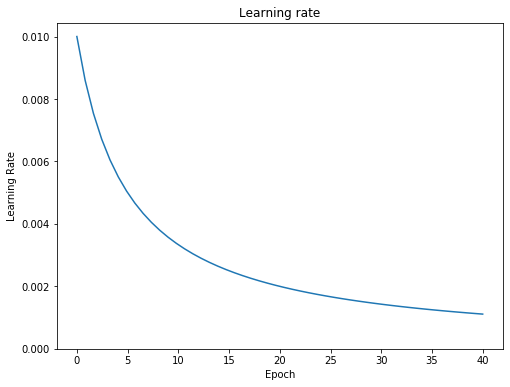

In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

train_size = 7400
batch_size = 128
epochs = 40
initial_learning_rate = 0.01
decay_rate = 0.2

# By using InverseTimeDecay
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = train_size // batch_size,
    decay_rate = decay_rate,
    staircase = False
)

# Plot the function
step_per_epoch = train_size // batch_size
step = np.linspace(0,step_per_epoch*epochs)

lr = lr_schedule(step)

plt.figure(figsize = (8,6))
plt.plot(step/step_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.title('Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate');

print (lr[35])
# opt = tf.keras.optimizers.SGD(lr_schedule)

### Data Augmentation

In [ ]:
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)

    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    #Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

### Keras Functional API (VS sequencial)

In [ ]:
def build_model(output_size, input_shape=(224, 224, 3), final_activation="softmax"):

    base_model = ResNet50(
        input_shape=input_shape,
        weights="imagenet",
        include_top=False
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    output = Dense(output_size, activation=final_activation)(x)
    
    return Model(outputs=output, inputs=base_model.input)


model = build_model(output_size = 23)

### Old way of adding findings from unlabeled ds to original training ds

In [ ]:
# Create a dataset with 1 sample from training dataset
for img, lab in train_ds.unbatch().take(1):
    pass

new_samples = tf.data.Dataset.from_tensors((img, lab))

pred_confidence = 0.90
new_samples_counter = 0

for batch in unlabeled_ds_test.batch(20):
    images, filenames = batch
    batch_preds = en_model.predict(images, verbose=0)
    
    for pred, image in zip(batch_preds, images):
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)
            pred_class = class_names[pred_idx]
            
            # print("{:>5.2f}% {}".format(highest_pred*100, pred_class))
            
            # Make a tensor of the unlabeled sample
            new_sample = tf.data.Dataset.from_tensors((image, pred_idx))
            # Add tensor to dataset
            new_samples = new_samples.concatenate(new_sample)
            new_samples_counter += 1
        
print ("Found", new_samples_counter, "new samples from unlabeled_ds_test")

In [ ]:
# Merge new dataset with original but exclude the first sample of dataset to add
new_train_ds = train_ds.unbatch().take(params["train_size"]).concatenate(new_samples.skip(1))

print ("Added new samples from unlabeled dataset to the training dataset")

In [ ]:
print ("Training dataset size:", params["train_size"])

num_elements = new_train_ds.reduce(0, lambda x, _: x + 1).numpy()
print ("New size:", num_elements)

### New way of adding findings (with lists)

In [ ]:
pred_confidence = 0.99
new_samples_counter = 0
total_time = time.time()
round_time = time.time()
img_list = []
lab_list = []
idx = 0

for image, label in unlabeled_ds:
    if not idx%1000: 
        print ("{:.1f}s\nBatch {}".format(time.time()-round_time,idx), end='')
        round_time = time.time()
    elif not idx%100:
        print (".",end='')
    img = np.expand_dims(image, 0)
    pred = en_model.predict(img)
    highest_pred = np.max(pred)
    if highest_pred > pred_confidence:
        pred_idx = np.argmax(pred).astype(np.int32)
        #pred_class = class_names[pred_idx]

        img_list.append(image)
        lab_list.append(pred_idx)

        new_samples_counter += 1
    idx += 1
        
print ("\nTotal time: {:.3f} s".format( time.time() - total_time ))
print ("Found", new_samples_counter, "new samples in unlabeled_ds")

### Iterate over dataset shards

Managed to cache the sharded dataset (64x64 res) for 1000 shards. Not good solution because  
- Takes loooong time to cache (and need to be cached to be usable)  
- Highly unifficient; need to run multiple resolutions.. So chache multiple times
- For iterating over student / teacher model multiple times there is no way to remove 'used' samples

In [ ]:
# Split the unlabeled dataset

ds_shards = []
num_splits = 1000 # yields 100 images in each split

for i in range(num_splits):
    ds_shards.append(unlabeled_ds.shard(num_shards=num_splits, index=i).cache('./cache/shard_'+str(i)+'tfcache'))

In [ ]:
num_elements = ds_shards[0].reduce(0, lambda x, _: x + 1).numpy()
print ("Each shard contains {} samples.".format(num_elements))

In [ ]:
import time 

for img, lab in train_ds.unbatch().take(1):
    pass
new_samples = tf.data.Dataset.from_tensors((img, lab))

pred_confidence = 0.90
new_samples_counter = 0
total_time = time.time()
round_time = time.time()

for i in range(0, 200):
    if not i%10:
        print ("{:.2f}s\nShard {}-{}:".format( time.time()-round_time, i, i+10 ), end='')
    else:
        print (".", end='')
    
    round_time = time.time()
    for batch in ds_shards[i].batch(10):
        images, filenames = batch
        batch_preds = en_model.predict(images, verbose=0)

        for pred, image in zip(batch_preds, images):
            highest_pred = np.max(pred)
            if highest_pred > pred_confidence:
                pred_idx = np.argmax(pred).astype(np.int32)
                pred_class = class_names[pred_idx]

                # print("{:>5.2f}% {}".format(highest_pred*100, pred_class))

                # Make a tensor of the unlabeled sample
                new_sample = tf.data.Dataset.from_tensors((image, pred_idx))
                # Add tensor to dataset
                new_samples = new_samples.concatenate(new_sample)
                new_samples_counter += 1
#     print ("{:.2f}s".format(time.time() - start1))
        
print ("\nAdded", new_samples_counter, "new samples to the training dataset")
print ("Total time {:.2f} s".format( time.time() - total_time ))

In [ ]:
# Merge new dataset with original but exclude the first sample of dataset to add
new_train_ds = train_ds.unbatch().take(params["train_size"]).concatenate(new_samples.skip(1))

print ("Added {} new samples from unlabeled dataset to the training dataset".format(new_samples_counter))

In [ ]:
print ("Old train_ds size:", params["train_size"])

num_elements = new_train_ds.reduce(0, lambda x, _: x + 1).numpy()
print ("New train_ds size:", num_elements)

### Iterate over take-datasets  
- Tar lenger tid per iterasjon av take/skip  
- Mye GPU/CPU idle time  
- 5000 bilder tok ~500s  


In [ ]:
import time

pred_confidence = 0.99
new_samples_counter = 0
dataset = unlabeled_ds
start = time.time()
img_list = []
lab_list = []

for i in range(20):
    round_time = time.time()
    print ("Batch {} | ".format(i), end='')
    
    shard = dataset.take(100)
    dataset = dataset.skip(100)
    
    images, filenames = next(iter(shard.batch(100))) # why batch?

    batch_preds = en_model.predict(images, verbose=0)

    for pred, image in zip(batch_preds, images):
        highest_pred = np.max(pred)

        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)
            #pred_class = class_names[pred_idx]
            img_list.append(image)
            lab_list.append(pred_idx)
            
            new_samples_counter += 1
    print ("{:.3f}s".format(time.time() - round_time))
print ("Time: {:.3f} s".format( time.time() - start ))
print ("Added", new_samples_counter, "new samples to the training dataset")

### Get size of dataset
- Only works if dataset is not repeated.

In [ ]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()